In [1]:
import os
import torch
import os, json, argparse, re
from typing import List, Optional, Tuple
from typing import Dict, Tuple, Optional, Union, List
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/wxy320/miniconda3/envs/oss/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
save_dir = "/expert/no_think_attn/Qwen3-8B/<reason>/MATH-500" 

files = sorted(f for f in os.listdir(save_dir) if f.endswith(".pt"))
model_name = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# for fname in files:
#     path = os.path.join(save_dir, fname)
#     data = torch.load(path, map_location="cpu")

In [ ]:
def show_data(data, start=0, end=140):
    prompt, full_ids, d = data['prom`pt'], data['full_ids'], data['d']
    prefix_k = len(d)
    token_ids = [] 
    seq_len = len(full_ids)
    suffix_len = seq_len - prefix_k
    # print(suffix_len)
    A = torch.empty(suffix_len, prefix_k, dtype=d[0]["attn_vals"].dtype)

    for i in range(prefix_k):
        attn_vals = d[i]["attn_vals"]          # length = seq_len-(i+1)
        # print(attn_vals.shape)
        token_id = d[i]['token_id']
        assert token_id == full_ids[i]
        A[:, i] = attn_vals[-suffix_len:]
        token_ids.append(token_id)

    prefix_k = len(d)
    attn_mean = A.mean(dim=0)              # [prefix_k]

    token_ids = full_ids[:prefix_k]             # [prefix_k]

    tokens = tokenizer.convert_ids_to_tokens(token_ids.tolist())

    tokens_last50 = tokens[start:end]
    attn_last50 = attn_mean[start:end]

    i = 0
    for tok, val in zip(tokens_last50, attn_last50):
        tok_disp = tok.replace("▁", " ").replace("Ġ", " ")
        print(f"{i}, {tok_disp:>12s}  {val.item():.6f}")
        i = i + 1

In [ ]:
import torch

def show_token_importance_oneline(
    data,
    tokenizer,
    start=0,
    end=140,
    normalize="slice",   # "slice" or "global"
    gamma=1.0,
    gap=""              
):
    full_ids, d = data["full_ids"], data["d"]
    prefix_k = len(d)
    seq_len = len(full_ids)
    suffix_len = seq_len - prefix_k
    if suffix_len <= 0 or prefix_k <= 0:
        return

    A = torch.empty(suffix_len, prefix_k, dtype=d[0]["attn_vals"].dtype, device=d[0]["attn_vals"].device)
    for i in range(prefix_k):
        assert d[i]["token_id"] == full_ids[i]
        A[:, i] = d[i]["attn_vals"][-suffix_len:]

    attn_mean = A.mean(dim=0).float()
    tokens = tokenizer.convert_ids_to_tokens(full_ids[:prefix_k].tolist())

    start = max(0, start)
    end = min(prefix_k, end)
    toks = tokens[start:end]
    vals = attn_mean[start:end]

    if normalize == "global":
        vmin, vmax = float(attn_mean.min()), float(attn_mean.max())
    else:
        vmin, vmax = float(vals.min()), float(vals.max())
    denom = (vmax - vmin) if vmax > vmin else 1.0

    def disp(tok: str) -> str:
        return tok.replace("▁", " ").replace("Ġ", " ").replace("Ċ", "\\n")

    def bg_red(t: float) -> str:
        t = max(0.0, min(1.0, t)) ** gamma
        g = int(255 * (1 - t))
        return f"\x1b[48;2;255;{g};{g}m"

    reset = "\x1b[0m"
    fg_black = "\x1b[30m"

    out = []
    for tok, val in zip(toks, vals):
        t = (float(val) - vmin) / denom
        s = disp(tok)
        if gap and (len(s) == 0 or s[0] != " "):
            s = gap + s
        out.append(f"{bg_red(t)}{fg_black}{s}{reset}")

    print("".join(out))
    print(f"[norm={normalize}, vmin={vmin:.4g}, vmax={vmax:.4g}, gamma={gamma}]")

In [5]:
import torch
import matplotlib.pyplot as plt

def show_and_save_token_importance_pdf(
    data,
    tokenizer,
    pdf_path,
    start=0,
    end=140,
    normalize="slice",      # "slice" or "global"
    gamma=1.0,
    font_size=10,
    max_chars_per_line=120,
    pad=0.12,
    x0=0.01,
    y0=0.98,
):
    """
    Matplotlib rendering of token importance with red background.
    - FIRST show the figure
    - THEN save to PDF
    - No print, no metadata text
    - '\\n' kept as literal text
    - Only token body is colored (leading spaces not colored)
    """

    # ------------------ 1. compute importance ------------------
    full_ids, d = data["full_ids"], data["d"]
    prefix_k = len(d)
    seq_len = len(full_ids)
    suffix_len = seq_len - prefix_k
    if suffix_len <= 0 or prefix_k <= 0:
        raise ValueError("Nothing to render")

    A = torch.empty(
        suffix_len, prefix_k,
        dtype=d[0]["attn_vals"].dtype,
        device=d[0]["attn_vals"].device
    )
    for i in range(prefix_k):
        assert d[i]["token_id"] == full_ids[i]
        A[:, i] = d[i]["attn_vals"][-suffix_len:]

    attn_mean = A.mean(dim=0).float().cpu()
    tokens = tokenizer.convert_ids_to_tokens(
        full_ids[:prefix_k].detach().cpu().tolist()
    )

    start = max(0, start)
    end = min(prefix_k, end)
    toks = tokens[start:end]
    vals = attn_mean[start:end]

    if normalize == "global":
        vmin, vmax = float(attn_mean.min()), float(attn_mean.max())
    else:
        vmin, vmax = float(vals.min()), float(vals.max())
    denom = (vmax - vmin) if vmax > vmin else 1.0

    # ------------------ helpers ------------------
    def to_text(tok: str) -> str:
        return tok.replace("▁", " ").replace("Ġ", " ").replace("Ċ", r"\n")

    def split_leading_spaces(s: str):
        i = 0
        while i < len(s) and s[i] == " ":
            i += 1
        return s[:i], s[i:]

    def red_face(t: float):
        t = max(0.0, min(1.0, t)) ** gamma
        g = 1.0 - t
        return (1.0, g, g)

    # ------------------ 2. line packing ------------------
    lines, cur, cur_len = [], [], 0
    for tok, v in zip(toks, vals):
        s = to_text(tok)
        lead, body = split_leading_spaces(s)
        seg_len = len(lead) + len(body)

        if cur and cur_len + seg_len > max_chars_per_line:
            lines.append(cur)
            cur, cur_len = [], 0

        cur.append((lead, body, float(v)))
        cur_len += seg_len

    if cur:
        lines.append(cur)

    # ------------------ 3. draw with matplotlib ------------------
    fig_h = max(1.2, 0.45 * len(lines))
    fig, ax = plt.subplots(figsize=(14, fig_h))
    ax.set_axis_off()

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    ax_bb = ax.get_window_extent(renderer=renderer)

    def draw_piece(x, y, text, bbox=None):
        if not text:
            return x
        t = ax.text(
            x, y, text,
            transform=ax.transAxes,
            fontsize=font_size,
            va="top", ha="left",
            bbox=bbox
        )
        fig.canvas.draw()
        bb = t.get_window_extent(renderer=renderer)
        return x + (bb.width / ax_bb.width)

    y = y0
    y_step = (y0 - 0.05) / max(1, len(lines))

    for line in lines:
        x = x0
        for lead, body, v in line:
            x = draw_piece(x, y, lead, None)
            if body:
                tnorm = (v - vmin) / denom
                bbox = dict(
                    boxstyle=f"square,pad={pad}",
                    facecolor=red_face(tnorm),
                    edgecolor="none"
                )
                x = draw_piece(x, y, body, bbox)
        y -= y_step

    # ------------------ 4. show then save ------------------
    plt.show()                      # 👈 先展示
    fig.savefig(pdf_path, bbox_inches="tight", dpi=300)
    plt.close(fig)

In [ ]:
modes = dict()
choose_file = 3
for mode in ['think', 'notag_think', '<reason>think' ,'no_think','notagno_think', '<reason>', '<begin>']:
    save_dir = f"/expert/no_think_attn/Qwen3-8B/{mode}/MATH-500"  # 你保存的目录
    files = sorted(f for f in os.listdir(save_dir) if f.endswith(".pt"))
    fname = files[choose_file]
    path = os.path.join(save_dir, fname)
    data = torch.load(path, map_location="cpu")
    modes[mode] = data

In [7]:
start=15
end=35
show_data(modes['think'], start=start, end=end)

0,         have  0.000535
1,            ?  0.000678
2,   <|im_end|>  0.000283
3,            Ċ  0.000684
4, <|im_start|>  0.000202
5,    assistant  0.000101
6,            Ċ  0.000205
7,      <think>  0.000069
8,            Ċ  0.000462
9,         Okay  0.001704
10,            ,  0.002306
11,           so  0.000301
12,            I  0.000591
13,         need  0.000259
14,           to  0.000167
15,       figure  0.000188
16,          out  0.000173
17,          how  0.000259
18,         many  0.000532
19,     positive  0.000330


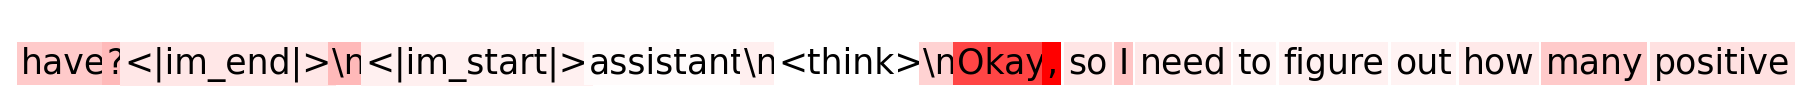

In [81]:
# show_token_importance(modes['think'], tokenizer, start=start, end=end,gamma=1.0,gap=' ',
#     save_pdf="./attn/think.pdf"
# )
show_and_save_token_importance_pdf(modes['think'], tokenizer, "./attn/think.png", start=start, end=end, 
                                   gamma=1.0,  font_size=25, x0=0, y0=0.6)

In [6]:
show_data(modes['notag_think'], start=start, end=end)

0,         have  0.000610
1,            ?  0.000738
2,   <|im_end|>  0.000299
3,            Ċ  0.000741
4, <|im_start|>  0.000230
5,    assistant  0.000101
6,           ĊĊ  0.000518
7,         Okay  0.001819
8,            ,  0.002089
9,           so  0.000322
10,            I  0.000622
11,         need  0.000296
12,           to  0.000174
13,       figure  0.000202
14,          out  0.000194
15,          how  0.000267
16,         many  0.000562
17,     positive  0.000325
18,        whole  0.000198
19,      -number  0.000256


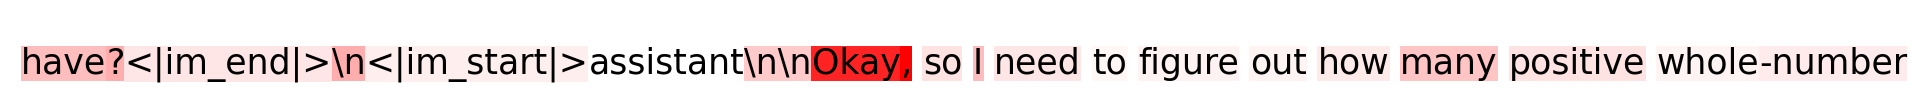

In [9]:
show_and_save_token_importance_pdf(modes['notag_think'], tokenizer, "./attn/notag_think.png", start=start, end=end, 
                                   gamma=1.0, pad=0.01, font_size=25, x0=0, y0=0.6)

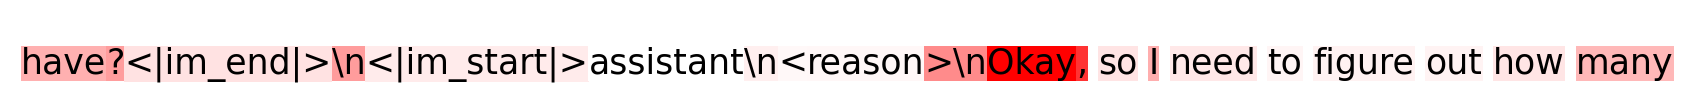

In [8]:
# show_data(modes['<reason>think'], start=start, end=end)
show_and_save_token_importance_pdf(modes['<reason>think'], tokenizer, "./attn/notag_reason_think.png", start=start, end=end, 
                                   gamma=1.0, pad=0.01, font_size=25, x0=0, y0=0.6)

In [8]:
show_data(modes['no_think'],  start=start, end=end)

0,         have  0.002733
1,            ?  0.004051
2,   <|im_end|>  0.001661
3,            Ċ  0.003550
4, <|im_start|>  0.000476
5,    assistant  0.000404
6,            Ċ  0.000880
7,      <think>  0.000282
8,           ĊĊ  0.002214
9,     </think>  0.002829
10,           ĊĊ  0.010010
11,           To  0.002510
12,         find  0.001223
13,          how  0.001373
14,         many  0.002300
15,           **  0.001418
16,     positive  0.001545
17,        whole  0.001130
18,      -number  0.001314
19,          div  0.001361


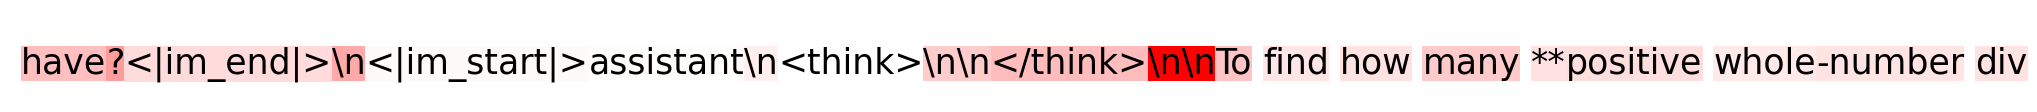

In [83]:
show_and_save_token_importance_pdf(modes['no_think'], tokenizer, "./attn/no_think.png", start=start, end=end, 
                                   gamma=1.0, pad=0.01, font_size=25, x0=0, y0=0.6)

In [13]:
show_data(modes['notagno_think'], start=start, end=end)

0,         have  0.000830
1,            ?  0.001019
2,   <|im_end|>  0.000362
3,            Ċ  0.000922
4, <|im_start|>  0.000300
5,    assistant  0.000119
6,            Ċ  0.000258
7,      <think>  0.000082
8,           ĊĊ  0.000751
9,     </think>  0.000513
10,          ĊĊĊ  0.002518
11,         Okay  0.001716
12,            ,  0.003193
13,           so  0.000456
14,            I  0.000983
15,         need  0.000440
16,           to  0.000274
17,       figure  0.000301
18,          out  0.000304
19,          how  0.000462


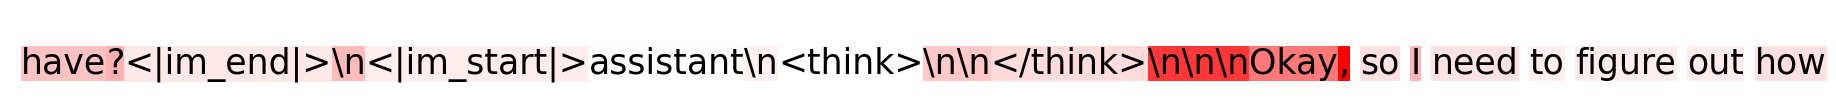

In [84]:
show_and_save_token_importance_pdf(modes['notagno_think'], tokenizer, "./attn/notagno_think.png", start=start, end=end, 
                                   gamma=1.0, pad=0.01,  font_size=25, x0=0, y0=0.6)

In [146]:
show_data(modes['<reason>'],  start=start, end=end)

0,         have  0.000904
1,            ?  0.001189
2,   <|im_end|>  0.000437
3,            Ċ  0.001097
4, <|im_start|>  0.000322
5,    assistant  0.000141
6,            Ċ  0.000303
7,      <think>  0.000096
8,           ĊĊ  0.000877
9,     </think>  0.000625
10,           ĊĊ  0.003836
11,            <  0.000365
12,       reason  0.000437
13,           >Ċ  0.001529
14,         Okay  0.001752
15,            ,  0.002232
16,           so  0.000462
17,            I  0.001001
18,         need  0.000442
19,           to  0.000275


In [147]:
show_data(modes['<begin>'],  start=start, end=end)

0,         have  0.001008
1,            ?  0.001229
2,   <|im_end|>  0.000413
3,            Ċ  0.001098
4, <|im_start|>  0.000336
5,    assistant  0.000154
6,            Ċ  0.000330
7,      <think>  0.000112
8,           ĊĊ  0.000953
9,     </think>  0.000695
10,           ĊĊ  0.004078
11,            <  0.000383
12,        begin  0.000397
13,           >Ċ  0.001274
14,         Okay  0.001692
15,            ,  0.003073
16,           so  0.000506
17,            I  0.001244
18,         need  0.000462
19,           to  0.000317
